In [2]:
import pandas as pd
import os

# Specify the input file path
file_path = r'/home/michael/Documenti/Milinda_Githubproject/Weibo and Twitter/twitter/train_posts_twitter.csv'

# Load the CSV file
df = pd.read_csv(file_path)

# Expand the 'image_id(s)' column to handle multiple IDs separated by commas
df_expanded = df.assign(image_id=df['image_id(s)'].astype(str).str.split(','))
df_expanded = df_expanded.explode('image_id').reset_index(drop=True)

# Drop the original "image_id(s)" column and keep only "image_id"
df_expanded = df_expanded.drop(columns=['image_id(s)'])
df_expanded.info()

# Generate the output file path in the same location
output_file_path = os.path.join(os.path.dirname(file_path), 'Rearranged_Train_Posts_Single_ImageID.csv')

# Save the rearranged dataframe to a CSV file in the same location
df_expanded.to_csv(output_file_path, index=False)

print(f"Rearranged file saved to: {output_file_path}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15872 entries, 0 to 15871
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        15872 non-null  float64
 1   post_text                      15872 non-null  object 
 2   user_id                        15872 non-null  int64  
 3   username                       15872 non-null  object 
 4   timestamp                      15872 non-null  object 
 5   label                          15872 non-null  object 
 6   general_knowledge_analysis     15872 non-null  object 
 7   unique_keyword_classification  15872 non-null  object 
 8   ml_model_prediction            15872 non-null  object 
 9   final_prediction               15872 non-null  object 
 10  image_id                       15872 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.3+ MB
Rearranged file saved to: /home/michael/Documenti

In [1]:
import pandas as pd
import os

# Paths for the files
rearranged_file_path = r'/home/michael/Documenti/Milinda_Githubproject/Weibo and Twitter/twitter/Rearranged_Train_Posts_Single_ImageID.csv'
predicted_labels_file_path = r'/home/michael/Documenti/Milinda_Githubproject/Weibo and Twitter/twitter/image_predicted_label_autoGlu_Twitter1.csv'

# Load the files
rearranged_df = pd.read_csv(rearranged_file_path)
image_predicted_df = pd.read_csv(predicted_labels_file_path)

# Remove extensions (.jpg, .png, etc.) from the 'image_id' column
if 'image_id' in image_predicted_df.columns:
    image_predicted_df['image_id'] = image_predicted_df['image_id'].str.replace(r'\.(jpg|png|jpeg|bmp|gif)$', '', regex=True)

# Merge the dataframes on 'image_id'
merged_df = pd.merge(rearranged_df, image_predicted_df, on='image_id', how='left')

# Remove rows with any empty (NaN) values
merged_df = merged_df.dropna()

merged_df.info()
# Save the merged dataframe to a new CSV file in the same directory as the rearranged file
merged_file_path = os.path.join(os.path.dirname(rearranged_file_path), 'Merged_Train_Posts_Image_Predicted_Cleaned1.csv')
merged_df.to_csv(merged_file_path, index=False)

print(f"Merged file saved to: {merged_file_path}")


<class 'pandas.core.frame.DataFrame'>
Index: 11961 entries, 0 to 11980
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        11961 non-null  float64
 1   post_text                      11961 non-null  object 
 2   user_id                        11961 non-null  int64  
 3   username                       11961 non-null  object 
 4   timestamp                      11961 non-null  object 
 5   label                          11961 non-null  object 
 6   general_knowledge_analysis     11961 non-null  object 
 7   unique_keyword_classification  11961 non-null  object 
 8   ml_model_prediction            11961 non-null  object 
 9   final_prediction               11961 non-null  object 
 10  image_id                       11961 non-null  object 
 11  Label                          11961 non-null  float64
 12  Mean                           11961 non-null  floa

Accuracy: 0.9774
Precision: 0.9921
Recall: 0.9698
F1 Score: 0.9808


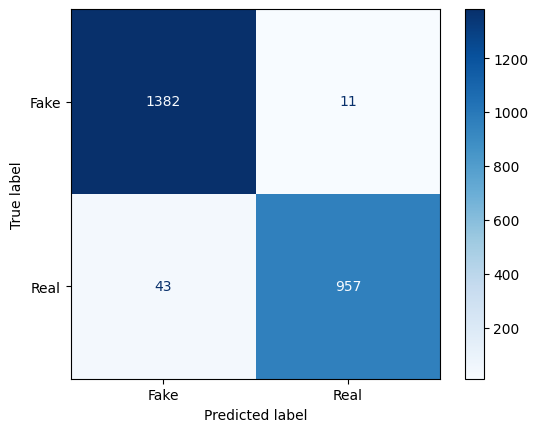

Accuracy for 100 hidden nodes using sigmoid: 0.9774


In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from numpy.linalg import pinv  # Use numpy's pinv as an alternative

# Load the data
filename_path = r'/home/michael/Documenti/Milinda_Githubproject/Weibo and Twitter/twitter/Merged_Train_Posts_Image_Predicted_Cleaned1.csv'
data = pd.read_csv(filename_path)

# Replace values in the 'final_prediction' column
data['final_prediction'] = data['final_prediction'].replace({"fake": 2, "TRUE": 1})

# Extract the relevant columns and preprocess
X = data[['final_prediction', 'predicted_label_image']].values
y = data['Label']  # Convert labels to integers

# Scale the input data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target labels
onehotencoder = OneHotEncoder(sparse_output=False)
y_encoded = onehotencoder.fit_transform(y.values.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define network parameters
input_size = X_train.shape[1]
hidden_size = 100

# Initialize input weights and biases
input_weights = np.random.normal(size=[input_size, hidden_size])
biases = np.random.normal(size=[hidden_size])

# Define sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Compute hidden layer nodes using sigmoid activation
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = sigmoid(G)
    return H

# Calculate output weights using pseudoinverse of hidden nodes
output_weights = np.dot(pinv(hidden_nodes(X_train)), y_train)

# Prediction function
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

# Run predictions on test data
prediction = predict(X_test)

# Compute the confusion matrix and performance metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

C = confusion_matrix(y_test.argmax(axis=1), prediction.argmax(axis=1))
TP = C[0, 0]
FP = C[0, 1]
FN = C[1, 0]
TN = C[1, 1]

accuracy = (TP + TN) / np.sum(C)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

# Display performance metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=C, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues')
plt.show()

# Evaluate accuracy
correct = 0
total = X_test.shape[0]
for i in range(total):
    predicted = np.argmax(prediction[i])
    actual = np.argmax(y_test[i])
    correct += 1 if predicted == actual else 0
accuracy = correct / total

print(f'Accuracy for {hidden_size} hidden nodes using sigmoid: {accuracy:.4f}')
